/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


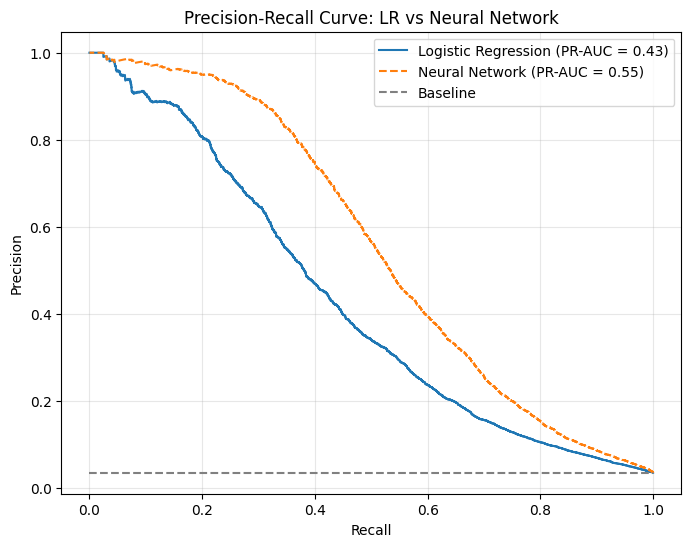

In [1]:
# ====== IMPORTS ======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import sparse
import joblib
import torch
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# ====== LOAD DATA ======
def load_data_optimized():
    transaction = pd.read_csv("../ieee-fraud-detection/train_transaction.csv",
                              usecols=lambda c: c != "TransactionDT")
    identity = pd.read_csv("../ieee-fraud-detection/train_identity.csv")
    df = transaction.merge(identity, on="TransactionID", how="left")
    return df

# ====== PREPROCESS (same as training) ======
def preprocess_data_optimized(df):
    y = df["isFraud"].astype(int)
    X = df.drop(columns=["isFraud"])

    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

    X[numeric_cols] = X[numeric_cols].fillna(0)
    X[categorical_cols] = X[categorical_cols].fillna("missing")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(with_mean=False), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
        ]
    )

    X_transformed = preprocessor.fit_transform(X)

    if not sparse.issparse(X_transformed):
        X_transformed = sparse.csr_matrix(X_transformed)

    return X_transformed, y, preprocessor

# ====== LOAD + PREPROCESS ======
df = load_data_optimized()
X_all, y_all, preprocessor = preprocess_data_optimized(df)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# ====== LOGISTIC REGRESSION ======
lr = joblib.load("models/logreg_lightweight.pkl")
probs_lr = lr.predict_proba(X_test)[:, 1]

# ====== NEURAL NETWORK ======
from fraud_net import FraudNet
device = "cuda" if torch.cuda.is_available() else "cpu"

# convert sparse -> dense
X_test_dense = X_test.toarray().astype(np.float32)
X_test_torch = torch.tensor(X_test_dense, device=device)

# load NN
input_dim = X_train.shape[1]
nn_model = FraudNet(input_dim=input_dim, hidden_sizes=(256, 64)).to(device)
nn_model.load_state_dict(torch.load("models/torch_nn_full.pt", map_location=device))
nn_model.eval()

with torch.no_grad():
    nn_probs = torch.sigmoid(nn_model(X_test_torch)).cpu().numpy()

# ====== PLOT PRECISION-RECALL CURVE ======
plt.figure(figsize=(8,6))

# LR curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, probs_lr)
pr_auc_lr = auc(recall_lr, precision_lr)
plt.plot(recall_lr, precision_lr, label=f"Logistic Regression (PR-AUC = {pr_auc_lr:.2f})")

# NN curve
precision_nn, recall_nn, _ = precision_recall_curve(y_test, nn_probs)
pr_auc_nn = auc(recall_nn, precision_nn)
plt.plot(recall_nn, precision_nn, label=f"Neural Network (PR-AUC = {pr_auc_nn:.2f})", linestyle="--")

# Baseline
baseline = y_test.mean()
plt.hlines(baseline, 0, 1, color='gray', linestyles='--', label="Baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: LR vs Neural Network")
plt.grid(alpha=0.3)
plt.legend()
plt.show()